In [113]:
#Importing all needed librarys
import torch
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from pipetorch.train import *
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout, GRU
from torch.optim import Adam, SGD
from tqdm import tqdm
from torch import nn, optim
import seaborn as sns
import torch.nn.functional as F

# importing the libraries
import pandas as pd
import numpy as np

# for creating validation set
from sklearn.model_selection import train_test_split


import torchvision
from torchvision.datasets import ImageFolder

In [114]:
#Checking wich GPU is beeing used

!nvidia-smi

Wed Dec  8 15:28:51 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.86       Driver Version: 470.86       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:05:00.0 Off |                  N/A |
| 29%   26C    P8    18W / 250W |   6740MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:09:00.0 Off |                  N/A |
| 29%   

In [115]:
#Load data
data_speaker1_dir = 'dialogue/Dataset/SameVoiceDetection/spectro/less_25_3_speaker1.npy'
#data_speaker1_dir = 'dialogue/Leander/outputs/speaker1.npy'
data_speaker2_dir = 'dialogue/Dataset/SameVoiceDetection/spectro/less_25_3_speaker2.npy'
#data_speaker2_dir = 'dialogue/Leander/outputs/speaker2.npy'
labels_dir = 'dialogue/Dataset/SameVoiceDetection/spectro/less_25_3_labels.npy'
#labels_dir = 'dialogue/Leander/outputs/labels.npy'

data_speaker1 = np.load(data_speaker1_dir, allow_pickle = True)
data_speaker2 = np.load(data_speaker2_dir, allow_pickle = True)
#data_speaker1 = data_speaker1.reshape((len(data_speaker1),40,len(data_speaker1[0])//40))
#data_speaker2 = data_speaker2.reshape((len(data_speaker2),40,len(data_speaker2[0])//40))
labels = np.load(labels_dir, allow_pickle = True)

print(data_speaker1.shape, data_speaker2.shape)
print(labels)

(2500, 128, 101) (2500, 128, 101)
[ True False  True ... False  True False]


In [116]:
#df_data.drop(['isSpeaking'],axis = 1)
X1_train, X1_val, y_train, y_val = train_test_split(data_speaker1, labels, test_size = 0.2, random_state = 23)
X1_train, X1_test, y_train, y_test = train_test_split(X1_train, y_train, test_size = 0.2, random_state = 23)

X2_train, X2_val, y_train, y_val = train_test_split(data_speaker2, labels, test_size = 0.2, random_state = 23)
X2_train, X2_test, y_train, y_test = train_test_split(X2_train, y_train, test_size = 0.2, random_state = 23)

print(type(X1_train))
#print(X_train)

<class 'numpy.ndarray'>


In [117]:
X1_train = torch.from_numpy(X1_train).float()

X2_train = torch.from_numpy(X2_train).float()

y_train = torch.from_numpy(y_train).float()

X1_val = torch.from_numpy(X1_val).float()

X2_val = torch.from_numpy(X2_val).float()

y_val = torch.from_numpy(y_val).float()

X1_test = torch.from_numpy(X1_test).float()

X2_test = torch.from_numpy(X2_test).float()

y_test = torch.from_numpy(y_test).float()

print(X2_train.shape, y_train.shape)

print(X2_train[0])


torch.Size([1600, 128, 101]) torch.Size([1600])
tensor([[2.0809e-01, 4.6489e-02, 3.6326e-02,  ..., 2.4664e-02, 2.5337e-02,
         1.2501e-02],
        [5.1111e-01, 1.1418e-01, 8.9223e-02,  ..., 6.0579e-02, 6.2232e-02,
         3.0704e-02],
        [4.4441e-02, 1.3550e+00, 1.0637e+00,  ..., 5.3121e-01, 1.0615e-01,
         6.3007e-04],
        ...,
        [1.4463e-06, 1.3515e-06, 1.0268e-06,  ..., 5.3672e-08, 5.1746e-07,
         3.6727e-07],
        [1.3140e-06, 1.2080e-06, 1.8192e-06,  ..., 1.6669e-07, 2.0465e-07,
         6.8783e-08],
        [7.5049e-07, 2.9321e-07, 6.6869e-07,  ..., 1.4681e-07, 1.3778e-07,
         1.4428e-08]])


In [118]:
class model(nn.Module):
    def __init__(self,n_features,kernel_size):
        super(model, self).__init__()
        print(n_features)
        self.conv1 = nn.Conv1d(n_features, 128, kernel_size=3, stride = 1) #40 input channels, 40 output channels
        self.conv2 = nn.Conv1d(128, 256, kernel_size=3, stride = 1) #40 input channels from previous Conv. layer, 80 out
        self.conv3 = nn.Conv1d(256, 80, kernel_size=3, stride = 1) #40 input channels from previous Conv. layer, 80 out

        self.fc1 = nn.Linear(15200, 1000) #Fully-connected classifier layer 
        self.fc2 = nn.Linear(1000, 100) #Fully-connected classifier layer
        self.fc3 = nn.Linear(100, 1) #Fully-connected classifier layer
    
    def forward_one_voice(self, x):
        x = F.relu(F.max_pool1d(self.conv1(x), 1))
        x = F.relu(F.max_pool1d(self.conv2(x), 1))
        x = F.relu(F.max_pool1d(self.conv3(x), 1))
        print(x.shape)
        x = x.reshape(len(x), -1)
        batch_size = len(x)
        print(batch_size)
        return x
    
    def forward(self, x1, x2):
        print(x1.shape, x2.shape)
        x1 = self.forward_one_voice(x1)
        x2 = self.forward_one_voice(x2)
        print(x1.shape, x2.shape)
        x = torch.concat([x1, x2], axis = 1)
        print(x.shape)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        return torch.sigmoid(x)
    
    def post_forward(self, y): 
        return torch.round(y)
    
CNN = model(X1_train.shape[1],kernel_size = 3)

128


In [119]:
weight = torch.FloatTensor([1])
criterion = nn.BCELoss()
optimizer = optim.Adam(CNN.parameters(), lr=0.00003)

In [120]:
train_ds = TensorDataset(X1_train, X2_train, y_train)
val_ds = TensorDataset(X1_val, X2_val, y_val)

In [121]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size= batch_size, num_workers = 4, pin_memory = True)
#val_dl = DataLoader(val_ds, batch_size= 32)

In [122]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# X1_train = X1_train.to(device)
# X2_train = X2_train.to(device)
# y_train = y_train.to(device)
X1_val = X1_val.to(device)
X2_val = X2_val.to(device)
y_val = y_val.to(device)

X1_test = X1_test.to(device)
X2_test = X2_test.to(device)
y_test = y_test.to(device)

CNN = CNN.to(device)
criterion = criterion.to(device)
print(device)

cuda


In [123]:
def calculate_accuracy(y_true, y_pred):
    return (y_true == y_pred).sum().float() / len(y_true)

In [124]:
def round_tensor(t, decimal_places=3):
    return round(t.item(), decimal_places)
    
Results = pd.DataFrame(columns = ['Epoch', 'Acc_train', 'Acc_val', 'val_loss', 'train_loss'])
    
for epoch in range(50):
    y_acc = torch.empty((batch_size),dtype= torch.int32, device = 'cuda')
    y_pred_acc = torch.empty((batch_size), device = 'cuda')
    for x1, x2, y in train_dl:
        x1, x2, y = x1.to(device), x2.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred = CNN(x1, x2)
        y_pred = y_pred.squeeze()
        train_loss = criterion(y_pred, y)
        train_loss.backward()
        optimizer.step()
        y_acc = torch.concat([y, y_acc], axis = 0)
        y_pred_acc = torch.concat([y_pred, y_pred_acc], axis = 0)
    if epoch % 1 == 0:


        train_acc = calculate_accuracy(y_acc, CNN.post_forward(y_pred_acc))
    
        y_val_pred = CNN(X1_val, X2_val)
        y_val_pred = y_val_pred.squeeze()
        val_loss = criterion(y_val_pred, y_val)
    
        val_acc = calculate_accuracy(y_val, CNN.post_forward(y_val_pred))
    
        result = {'Epoch': epoch, 'Acc_train': round_tensor(train_acc), 'Acc_val': round_tensor(val_acc), 'val_loss': round_tensor(val_loss), 'train_loss': round_tensor(train_loss)}

        Results = Results.append(result, ignore_index=True)

        print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
val  set - loss: {round_tensor(val_loss)}, accuracy: {round_tensor(val_acc)}
''')

torch.Size([32, 128, 101]) torch.Size([32, 128, 101])
torch.Size([32, 128, 101]) torch.Size([32, 128, 101])
torch.Size([32, 80, 95])
32
torch.Size([32, 80, 95])
32
torch.Size([32, 7600]) torch.Size([32, 7600])
torch.Size([32, 15200])
torch.Size([32, 128, 101]) torch.Size([32, 128, 101])
torch.Size([32, 128, 101]) torch.Size([32, 128, 101])
torch.Size([32, 80, 95])
32
torch.Size([32, 80, 95])
32
torch.Size([32, 7600]) torch.Size([32, 7600])
torch.Size([32, 15200])
torch.Size([32, 128, 101]) torch.Size([32, 128, 101])
torch.Size([32, 128, 101]) torch.Size([32, 128, 101])
torch.Size([32, 80, 95])
32
torch.Size([32, 80, 95])
32
torch.Size([32, 7600]) torch.Size([32, 7600])
torch.Size([32, 15200])
torch.Size([32, 128, 101]) torch.Size([32, 128, 101])
torch.Size([32, 128, 101]) torch.Size([32, 128, 101])
torch.Size([32, 80, 95])
32
torch.Size([32, 80, 95])
32
torch.Size([32, 7600]) torch.Size([32, 7600])
torch.Size([32, 15200])
torch.Size([32, 128, 101]) torch.Size([32, 128, 101])
torch.Size

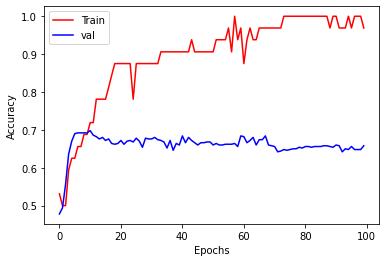

    Epoch  Acc_train  Acc_val  val_loss  train_loss
0     0.0      0.531    0.478     0.694       0.694
1     1.0      0.500    0.494     0.694       0.695
2     2.0      0.500    0.556     0.688       0.699
3     3.0      0.594    0.636     0.658       0.711
4     4.0      0.625    0.670     0.636       0.727
..    ...        ...      ...       ...         ...
95   95.0      0.969    0.656     6.208       0.142
96   96.0      1.000    0.648     5.757       0.008
97   97.0      1.000    0.648     6.409       0.026
98   98.0      1.000    0.648     5.946       0.006
99   99.0      0.969    0.658     6.617       0.115

[100 rows x 5 columns]


In [125]:
plt.plot(Results.Epoch,Results.Acc_train,'r',Results.Epoch,Results.Acc_val,'b')
plt.legend(['Train','val'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
print(Results)

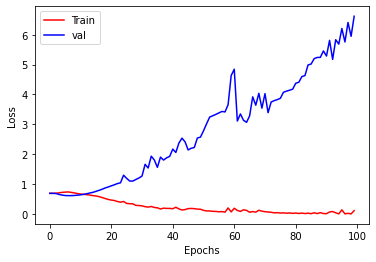

In [126]:
plt.plot(Results.Epoch,Results.train_loss,'r',Results.Epoch,Results.val_loss,'b')
plt.legend(['Train','val'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [127]:
classes = ['Different Voice', 'Same Voice']
y_pred = CNN(X1_val, X2_val)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_val = y_val.cpu()
print(classification_report(y_val, y_pred, target_names=classes))

torch.Size([500, 128, 101]) torch.Size([500, 128, 101])
torch.Size([500, 80, 95])
500
torch.Size([500, 80, 95])
500
torch.Size([500, 7600]) torch.Size([500, 7600])
torch.Size([500, 15200])
                 precision    recall  f1-score   support

Different Voice       0.68      0.60      0.64       250
     Same Voice       0.64      0.72      0.68       250

       accuracy                           0.66       500
      macro avg       0.66      0.66      0.66       500
   weighted avg       0.66      0.66      0.66       500



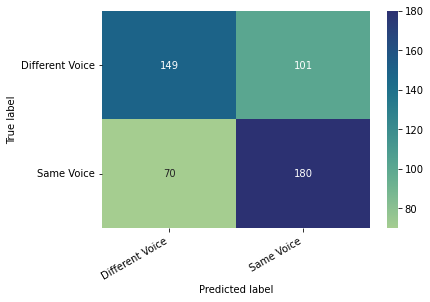

In [128]:
cm = confusion_matrix(y_val, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [129]:
y_pred = CNN(X1_test, X2_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

torch.Size([400, 128, 101]) torch.Size([400, 128, 101])
torch.Size([400, 80, 95])
400
torch.Size([400, 80, 95])
400
torch.Size([400, 7600]) torch.Size([400, 7600])
torch.Size([400, 15200])
                 precision    recall  f1-score   support

Different Voice       0.69      0.65      0.67       204
     Same Voice       0.66      0.69      0.67       196

       accuracy                           0.67       400
      macro avg       0.67      0.67      0.67       400
   weighted avg       0.67      0.67      0.67       400



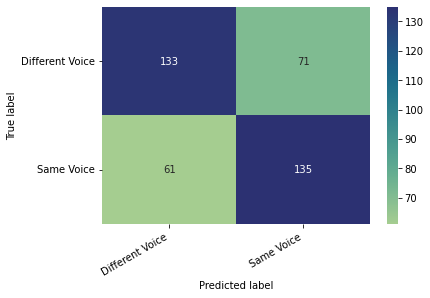

In [130]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap= 'crest')
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

In [131]:
#Shutting down the notebook

%%javascript
Jupyter.notebook.session.delete();

UsageError: Line magic function `%%javascript` not found.
